## Import Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow import get_logger
get_logger().setLevel("ERROR")

In [2]:
from typing import Tuple

import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import random

# model preprocessing & evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.random import set_seed

In [3]:
SEED = 1412
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

In [4]:
sns.set_color_codes(palette="deep")   
sns.set_style(style="whitegrid")

## Data

In [5]:
df = pd.read_csv("data/dangcem.csv")

# Convert date variable to date data type
df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(by="date").reset_index(drop=True)

dangcem = df.loc[df["date"] >= "2023-01-01"]
dangcem = dangcem[["date", "close"]].set_index('date')

dangcem.head()

,close
date,
2023-01-03,261.0
2023-01-04,261.0
2023-01-05,261.0
2023-01-06,262.0
2023-01-09,262.0


## Model

In [6]:
# Load the trained LSTM model
model = load_model('model/stock_lstm.h5')

In [ ]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(dangcem)

In [31]:
# Function to create sequences
def create_sequences(data, seq_length):
    X = []

    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        
    return np.array(X)

In [30]:
# Best sequence length from training
seq_length = 15

In [29]:
# Function to make predictions
def make_predictions(model, sequence, steps):
    """
    this function uses the provided model to make multiple step-ahead predictions.
    
    model: The trained LSTM model
    sequence: The input sequence of data
    steps: The number of future steps to predict
    """
    # Initializes an empty list to store the predictions.
    predictions = []
    # Creates a copy of the input sequence to avoid modifying the original data.
    curr_sequence = sequence.copy()
    # Loop through the steps number of times.
    for _ in range(steps):
        # Predic and extracts the scalar prediction value from the model's output.
        next_pred = model.predict(curr_sequence.reshape(1, seq_length, 1))[0][0]
        predictions.append(next_pred)
        # Shift all elements in curr_sequence to the left by one position.
        curr_sequence = np.roll(curr_sequence, -1)
        # Replaces the last element of curr_sequence with the newly predicted value.
        curr_sequence[-1] = next_pred
    
    return np.array(predictions)

In [28]:
# Trading strategy function
def trading_strategy(df, model, scaler, prediction_days, buy_threshold, sell_threshold, stop_loss, take_profit, strategy_type):
    scaled_data = scaler.transform(df)
    position = 0  # 0: no position, 1: long position
    entry_price = 0
    trades = []
    equity = [10000]  # Starting equity N10,000

    # Iterates through the dataframe df, starting from seq_length
    for i in range(seq_length, len(df)):
        # Creates a sequence of the last seq_length scaled data points up to the current index i
        sequence = scaled_data[i-seq_length:i, 0]
        # Take the last prediction ([-1]) for the specified number of prediction_days.
        prediction = make_predictions(model, sequence, prediction_days)[-1]
        # Get the current closing price from the dataframe.
        current_price = df['close'].iloc[i]
        # Calculates the percentage return based on the current price
        predicted_return = (scaler.inverse_transform([[prediction]])[0][0] - current_price) / current_price

        if position == 0:  # No current position
            if predicted_return > buy_threshold:
                position = 1
                entry_price = current_price
                trades.append(('BUY', current_price, df.index[i]))
        elif position == 1:  # A Long position
            returns = (current_price - entry_price) / entry_price
            if predicted_return < sell_threshold or returns <= stop_loss or returns >= take_profit:
                position = 0
                trades.append(('SELL', current_price, df.index[i]))
                equity.append(equity[-1] * (1 + returns))

    # Calculate strategy performance
    returns = pd.Series(equity).pct_change()
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    max_drawdown = (pd.Series(equity).cummax() - equity).max() / pd.Series(equity).cummax()

    print(f"{strategy_type} Strategy Results:")
    print(f"Final Equity: N{equity[-1]:.2f}")
    print(f"Total Return: {(equity[-1] - equity[0]) / equity[0]:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: ")
    print(max_drawdown)

    return trades, equity, sharpe_ratio, max_drawdown

In [47]:
# Function to run and plot strategy
def plot_strategy(df, trades, strategy_type):

    # Plot results
    plt.figure(figsize=(8, 4))
    plt.plot(df.index, df['close'], label='Dangote Cement Price', color="#BC6C25")

    buy_dates = [trade[2] for trade in trades if trade[0] == 'BUY']
    sell_dates = [trade[2] for trade in trades if trade[0] == 'SELL']
    buy_prices = [trade[1] for trade in trades if trade[0] == 'BUY']
    sell_prices = [trade[1] for trade in trades if trade[0] == 'SELL']
    
    plt.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, label='Buy Signal')
    plt.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, label='Sell Signal')
    

    plt.title(f'LSTM-based {strategy_type} Trading Strategy for Dangote Cement')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()


### Short Term

In [32]:
# Run short-term strategy 

s_trades, s_equity, s_sharpe_ratio, s_max_drawdown = trading_strategy(
    df=dangcem, 
    model=model, 
    scaler=mm_scaler, 
    prediction_days=3, 
    buy_threshold=0.01, 
    sell_threshold=-0.005, 
    stop_loss=-0.05, 
    take_profit=0.1,
    strategy_type="Short-term"
)

1/1 [==============================] - 0s 88ms/step
Short-term Strategy Results:
Final Equity: N13533.30
Total Return: 35.33%
Sharpe Ratio: 17.69
Max Drawdown: 
0    0.000423
1    0.000415
2    0.000395
3    0.000368
4    0.000368
5    0.000336
6    0.000331
7    0.000313
8    0.000313
dtype: float64


In [60]:
print(f"Short-Term Strategy Results:")
print(f"Final Equity: N{s_equity[-1]:,.2f}")
print(f"Total Return: {(s_equity[-1] - s_equity[0]) / s_equity[0]:.2%}")
print(f"Sharpe Ratio: {s_sharpe_ratio:.2f}")
print(f"Max Drawdown: ")
print(s_max_drawdown)

Short-Term Strategy Results:
Final Equity: N13,533.30
Total Return: 35.33%
Sharpe Ratio: 17.69
Max Drawdown: 
0    0.000423
1    0.000415
2    0.000395
3    0.000368
4    0.000368
5    0.000336
6    0.000331
7    0.000313
8    0.000313
dtype: float64


In [40]:
s_trades

[('BUY', 265.0, Timestamp('2023-02-07 00:00:00')),
 ('SELL', 270.0, Timestamp('2023-02-08 00:00:00')),
 ('BUY', 276.0, Timestamp('2023-03-28 00:00:00')),
 ('SELL', 290.0, Timestamp('2023-03-29 00:00:00')),
 ('BUY', 270.0, Timestamp('2023-03-31 00:00:00')),
 ('SELL', 290.0, Timestamp('2023-05-30 00:00:00')),
 ('BUY', 326.0, Timestamp('2023-07-12 00:00:00')),
 ('SELL', 326.0, Timestamp('2023-07-13 00:00:00')),
 ('BUY', 320.0, Timestamp('2023-08-09 00:00:00')),
 ('SELL', 349.9, Timestamp('2023-08-10 00:00:00')),
 ('BUY', 334.0, Timestamp('2023-09-22 00:00:00')),
 ('SELL', 340.0, Timestamp('2023-09-29 00:00:00')),
 ('BUY', 310.1, Timestamp('2023-10-06 00:00:00')),
 ('SELL', 328.0, Timestamp('2023-10-30 00:00:00')),
 ('BUY', 320.0, Timestamp('2023-11-28 00:00:00')),
 ('SELL', 319.9, Timestamp('2023-12-28 00:00:00'))]

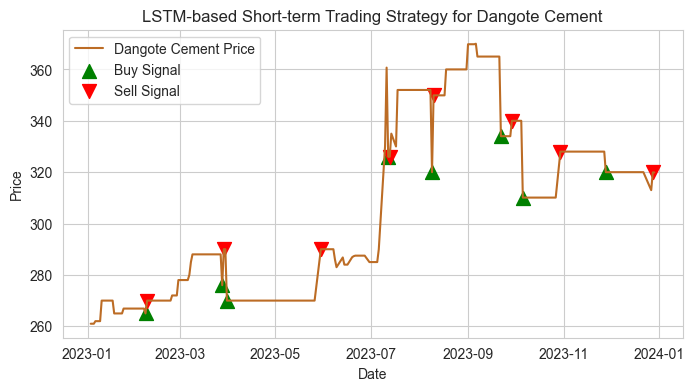

In [50]:
plot_strategy(df=dangcem, trades=s_trades, strategy_type="Short-term")
plt.savefig('images/trad_sys_short_pred.png')
plt.show()

### Long-Term

In [37]:
l_trades, l_equity, l_sharpe_ratio, l_max_drawdown = trading_strategy(
    df=dangcem, 
    model=model, 
    scaler=mm_scaler, 
    prediction_days=30, 
     buy_threshold=0.05,
    sell_threshold=-0.03,
    stop_loss=-0.1,
    take_profit=0.2,
    strategy_type="Long-term"
)

1/1 [==============================] - 0s 51ms/step
Long-term Strategy Results:
Final Equity: N12645.40
Total Return: 26.45%
Sharpe Ratio: 30.09
Max Drawdown: 
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64


In [57]:
print(f"Short-Term Strategy Results:")
print(f"Final Equity: N{l_equity[-1]:,.2f}")
print(f"Total Return: {(l_equity[-1] - l_equity[0]) / l_equity[0]:.2%}")
print(f"Sharpe Ratio: {l_sharpe_ratio:.2f}")
print(f"Max Drawdown: ")
print(l_max_drawdown)

Short-Term Strategy Results:
Final Equity: N12,645.40
Total Return: 26.45%
Sharpe Ratio: 30.09
Max Drawdown: 
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64


In [39]:
l_trades

[('BUY', 270.0, Timestamp('2023-03-31 00:00:00')),
 ('SELL', 290.0, Timestamp('2023-05-30 00:00:00')),
 ('BUY', 320.0, Timestamp('2023-08-09 00:00:00')),
 ('SELL', 349.9, Timestamp('2023-08-10 00:00:00')),
 ('BUY', 334.0, Timestamp('2023-09-22 00:00:00')),
 ('SELL', 340.0, Timestamp('2023-09-29 00:00:00')),
 ('BUY', 310.1, Timestamp('2023-10-06 00:00:00')),
 ('SELL', 328.0, Timestamp('2023-10-30 00:00:00'))]

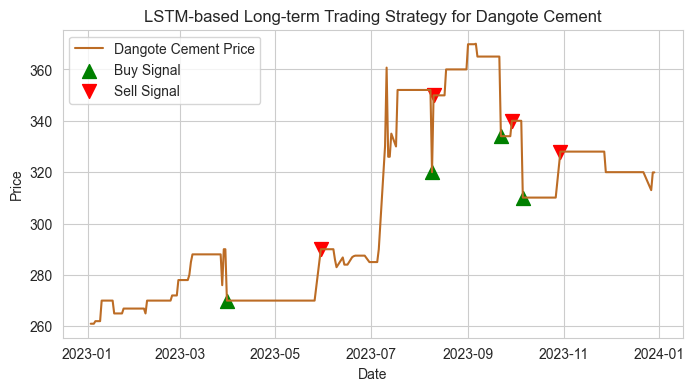

In [51]:
# Run long-term strategy

plot_strategy(df=dangcem, trades=l_trades, strategy_type="Long-term")
plt.savefig('images/trad_sys_long_pred.png')
plt.show()